<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-A" data-toc-modified-id="Part-A-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Part A</a></span></li><li><span><a href="#Part-B" data-toc-modified-id="Part-B-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part B</a></span></li><li><span><a href="#Part-C" data-toc-modified-id="Part-C-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part C</a></span></li></ul></div>

# Homework - Exercise 6 Text Clustering

## Part A

In [1]:
import numpy as np
import pandas as pd
from seaborn import heatmap 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from gensim import corpora, models
from pyLDAvis.gensim_models import prepare
import pickle
import pyLDAvis

In [37]:
df = pd.read_json("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")

In [38]:
with open("../../data/data_stemmed.pkl", "rb") as input_file:
    df["preprocessed"] = pickle.load(input_file)

In [39]:
df.head(2)

,content,target,target_names,preprocessed
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,car wonder enlighten car saw dai door sport ca...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,clock poll final final clock report acceler cl...


In [40]:
# Filter for topics
topics = ['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']
df = df.loc[df.target_names.isin(topics),:]

In [42]:
#Store the frequency matrix in data_tfidf
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, min_df=0.1)
data_tfidf = tfidf_vectorizer.fit_transform(df.preprocessed)

In [43]:
#Store the feature names in a words list
words = tfidf_vectorizer.get_feature_names_out()

## Part B

In [44]:
kmeans = KMeans(n_clusters = 4, max_iter=1000, random_state=42)
kmeans.fit(data_tfidf)

KMeans(max_iter=1000, n_clusters=4, random_state=42)

What are we trying to achieve with this method?
- Cluster the tdif_data of the newsgroups post into 4 clusters using kMeans

In [45]:
# Get index of 10 words which are at the cluster center
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]

In [46]:
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : god, christian, believ, peopl, edu, think, know, question, rutger, mean
1 : edu, israel, write, peopl, articl, post, new, know, time, like
2 : bike, com, dod, articl, write, edu, like, apr, good, post
3 : game, team, plai, hockei, edu, year, write, new, think, time


In [48]:
df["cluster"] = kmeans.labels_

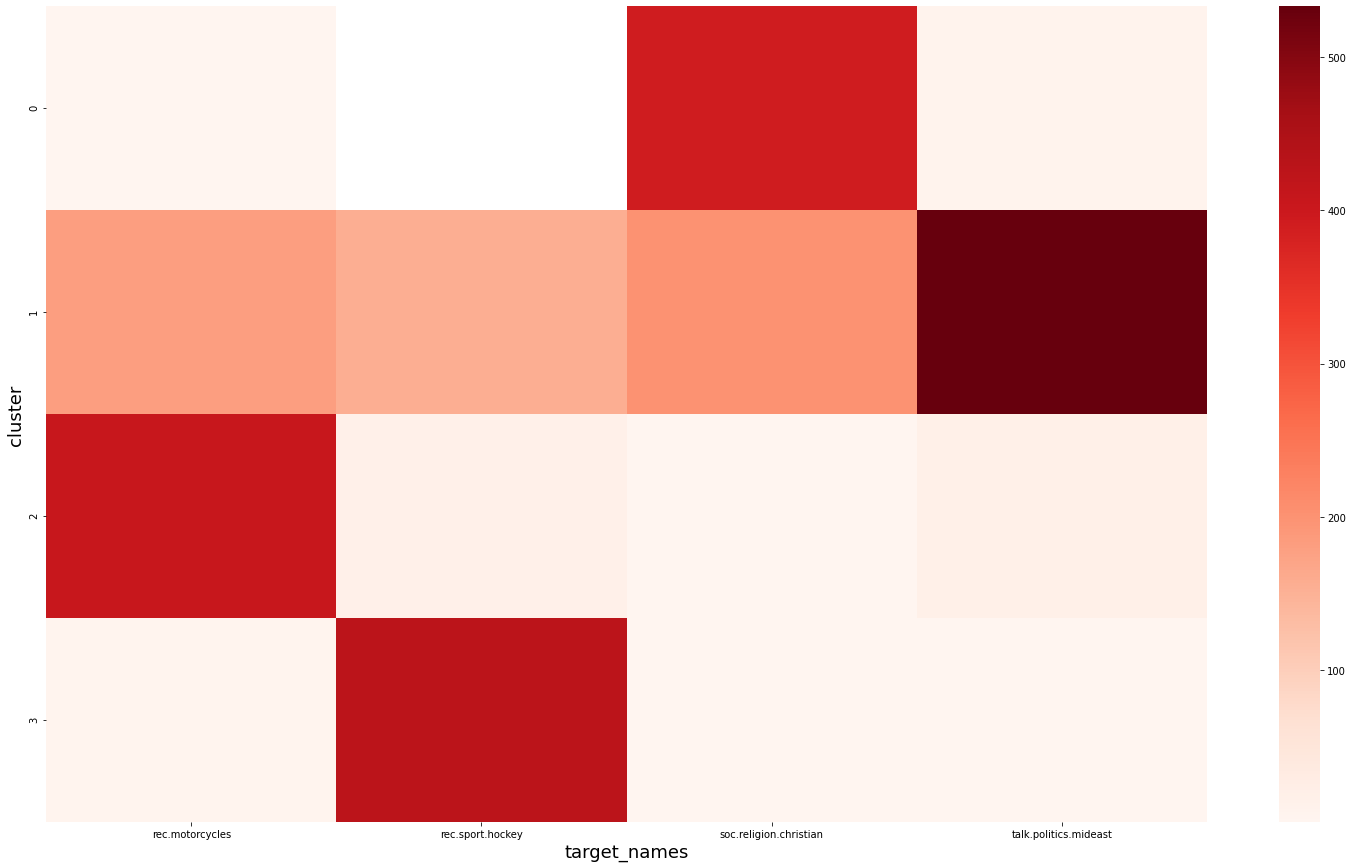

In [49]:
clusters = df.groupby(['cluster', 'target_names']).size()
fig, ax1 = plt.subplots(figsize = (26, 15))
heatmap(clusters.unstack(level = 'target_names'), ax = ax1, cmap = 'Reds')
ax1.set_xlabel('target_names').set_size(18)
ax1.set_ylabel('cluster').set_size(18)

Overall the heatmap confirms our clustering, since most of the postings wer category where correctly classified, but especially cluster 1 seems to be to "broad" so that a conisderable amount of postings from the other targets are assigned to it.

Add a column pred to the data frame setting its values to the target you would expect in 4. i.e. if you think that cluster 0 should correspond to topic rec.motorcycles, then all datapoints with df['cluster']==0 would get pred set to 8.


In [63]:
# Dictonary to map clusert_id to target_id
mapping = {0: 15, 1:17, 2:8, 3:10}

In [64]:
df["pred"] = df.cluster.apply(lambda x: mapping[x])

In [65]:
print(classification_report(df.target, df.pred))

              precision    recall  f1-score   support

           8       0.91      0.68      0.78       598
          10       0.97      0.71      0.83       600
          15       0.97      0.66      0.78       599
          17       0.50      0.95      0.65       564

    accuracy                           0.75      2361
   macro avg       0.84      0.75      0.76      2361
weighted avg       0.85      0.75      0.76      2361



## Part C

In [79]:
list_words = [sentence.split() for sentence in df.preprocessed]
dictionary = corpora.Dictionary(list_words)

In [80]:
dictionary.filter_extremes(no_below=118, no_above=0.95)

In [81]:
corpus = [dictionary.doc2bow(doc) for doc in list_words]

In [83]:
lda = models.LdaModel(corpus, num_topics=4, id2word=dictionary, chunksize=10, 
                      iterations=100, passes=10, random_state=42)

In [93]:
lda.show_topics()

[(0, '0.058*"edu" + 0.039*"write" + 0.029*"articl" + 0.027*"like" + 0.027*"com" + 0.022*"post" + 0.021*"time" + 0.020*"think" + 0.018*"apr" + 0.016*"good"'), (1, '0.070*"team" + 0.050*"game" + 0.048*"hockei" + 0.035*"plai" + 0.029*"armenian" + 0.029*"year" + 0.027*"win" + 0.027*"wing" + 0.027*"turkish" + 0.025*"nhl"'), (2, '0.053*"god" + 0.043*"peopl" + 0.036*"know" + 0.028*"christian" + 0.027*"believ" + 0.023*"reason" + 0.020*"wai" + 0.018*"evid" + 0.016*"jesu" + 0.016*"come"'), (3, '0.070*"israel" + 0.052*"isra" + 0.040*"jew" + 0.039*"state" + 0.033*"kill" + 0.032*"arab" + 0.029*"war" + 0.027*"attack" + 0.026*"govern" + 0.026*"public"')]

Assign to each topic one target from the dataset similar to Question 4.

In [88]:
topics=lda[corpus]
df['topics_lda']= [max(topics[i],key=lambda item:item[1])[0] for i in range(len(topics))]

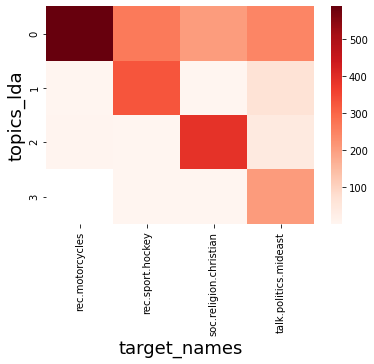

In [96]:
clusters = df.groupby(['topics_lda', 'target_names']).size()
fig, ax1 = plt.subplots()
heatmap(clusters.unstack(level = 'target_names'), ax = ax1, cmap = 'Reds')
ax1.set_xlabel('target_names').set_size(18)
ax1.set_ylabel('topics_lda').set_size(18)

In [97]:
df

,content,target,target_names,preprocessed,cluster,pred,topics_lda
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles,recommend duc worth ducati gt line ducati gt m...,2,8,0
21,From: leunggm@odin.control.utoronto.ca (Gary L...,10,rec.sport.hockey,nhl team captain articl apr samba oit unc edu ...,3,10,0
28,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian,pantheism environment articl apr atho rutger e...,0,15,0
33,From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...,17,talk.politics.mideast,isra expans lust articl spam math adelaid edu ...,1,17,3
35,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey,goali mask articl netnew upenn edu kkeller mai...,1,17,0
...,...,...,...,...,...,...,...
11298,From: cbetz@radioman.cray.com (Charles Betz {...,10,rec.sport.hockey,nhl team milwauke read report possibl nhl move...,3,10,1
11299,From: 2120788@hydra.maths.unsw.EDU.AU ()\nSubj...,17,talk.politics.mideast,turkei cypru bosnia serbia greec armenia azeri...,1,17,0
11300,From: aa888@freenet.carleton.ca (Mark Baker)\n...,15,soc.religion.christian,arrog christian previou articl phsd vaxc monas...,0,15,2
11305,From: shaig@composer.think.com (Shai Guday)\nS...,17,talk.politics.mideast,hezbollah apr yuma acn colost edu nntp post ho...,1,17,3


In [102]:
# Dictonary to map clusert_id to target_id
mapping = {0: 8, 1:10, 2:15, 3:17}

df["pred_lda"] = df.topics_lda.apply(lambda x: mapping[x])

In [103]:
print(classification_report(df.target, df.pred_lda))

              precision    recall  f1-score   support

           8       0.45      0.98      0.62       598
          10       0.82      0.55      0.66       600
          15       0.88      0.65      0.75       599
          17       0.98      0.37      0.53       564

    accuracy                           0.64      2361
   macro avg       0.78      0.64      0.64      2361
weighted avg       0.78      0.64      0.64      2361



Interestingly here the politics topic is the hardest to predict correctly and motorcycles have the highest precision

In [91]:
pyLDAvis.enable_notebook()
LDAvis_prepared = prepare(lda, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.186274 -0.210517       1        1  40.990513
2     -0.247370  0.188477       2        1  29.193029
1     -0.190975 -0.181204       3        1  16.733466
3      0.252071  0.203244       4        1  13.082992, topic_info=       Term         Freq        Total Category  logprob  loglift
28     team  1501.000000  1501.000000  Default  30.0000  30.0000
42      god  1996.000000  1996.000000  Default  29.0000  29.0000
81   israel  1172.000000  1172.000000  Default  28.0000  28.0000
18      edu  3103.000000  3103.000000  Default  27.0000  27.0000
199    game  1072.000000  1072.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
273    case   186.117117   394.069464   Topic4  -4.5034   1.2837
95     said   254.471539   842.071558   Topic4  -4.1906   0.8372
88     live   216.782612   779.106403   Topic4  -4.3509   0.7546
265    fact   191.349416   587.797229   Topic4  -4.4757   0.9116
7       org   150.371704   302.290116   Topic4  -4.7167   1.3356

[197 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
322       2  0.295816    action
322       4  0.699629    action
69        1  0.995737    actual
128       1  0.995186      agre
205       3  0.002761  american
...     ...       ...       ...
157       3  0.150345     world
31        1  0.948278     write
31        4  0.051359     write
115       1  0.489196      year
115       3  0.510430      year

[228 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])